\begin{equation*}
\left\{
\begin{array}{ll}
    u_t - a(u^2)_x + b u_{xxx} = 0, & -14 \leq x \leq 16,\quad 0 < t \leq 0.5, \\[10pt]
    u(x,0) = -2sech^2(x), & -14 < x < 16, \\[10pt]
    u(-14, t) = -2sech^2(-14 - 4t), & t \geq 0, \\[10pt]
    u(16, t) = -2sech^2(16 - 4t), & t \geq 0.
\end{array}
\right.
\end{equation*}

Analytical Solution:
\begin{equation}
u(x, t) = -2\, \mathrm{sech}^2(x - 4t).
\end{equation}


In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
nx, nt = 200, 100
x = np.linspace(-14, 16, nx)
t = np.linspace(0, 0.5, nt)
X, T = np.meshgrid(x, t)


def u_exact(x, t):
    return -2 / np.cosh(x - 4*t)**2

U = u_exact(X, T)

dx = x[1] - x[0]
dt = t[1] - t[0]


def derivative(f, axis, dx):
    return (np.roll(f, -1, axis=axis) - np.roll(f, 1, axis=axis)) / (2*dx)

def third_derivative(f, axis, dx):
    return (np.roll(f, -2, axis=axis) - 2*np.roll(f, -1, axis=axis) + 2*np.roll(f, 1, axis=axis) - np.roll(f, 2, axis=axis)) / (2*dx**3)

u = U[2:-2, 2:-2]
u_t = derivative(U, axis=0, dx=dt)[2:-2, 2:-2]
u2_x = derivative(U**2, axis=1, dx=dx)[2:-2, 2:-2]
u_xxx = third_derivative(U, axis=1, dx=dx)[2:-2, 2:-2]

u_t_flat = u_t.flatten()
u2_x_flat = u2_x.flatten()
u_xxx_flat = u_xxx.flatten()


X_data = np.stack([u2_x_flat, u_xxx_flat], axis=1)
y_data = u_t_flat

reg = LinearRegression(fit_intercept=False)
reg.fit(X_data, y_data)
a_est, b_est = reg.coef_


print(f"Estimated coefficients:")
print(f"a ≈ {a_est:.5f}")
print(f"b ≈ {-b_est:.5f}")

print("\nIdentified PDE:")
print(f"u_t - {a_est:.5f} * (u^2)_x + {(-b_est):.5f} * u_xxx = 0")

y_pred = reg.predict(X_data)
print("R² score:", np.corrcoef(y_data, y_pred)[0,1]**2)


Estimated coefficients:
a ≈ 3.02593
b ≈ 1.01644

Identified PDE:
u_t - 3.02593 * (u^2)_x + 1.01644 * u_xxx = 0
R² score: 0.9999246149255877


epoch     0   loss = 2.5062e+00
epoch   200   loss = 2.3923e+00
epoch   400   loss = 3.2099e-04
epoch   600   loss = 8.6206e-05
epoch   800   loss = 3.9567e-03
epoch  1000   loss = 3.0596e-02
epoch  1200   loss = 4.0848e-05
epoch  1400   loss = 4.9032e-05
epoch  1600   loss = 1.7724e-04
epoch  1800   loss = 7.2558e-05
epoch  2000   loss = 3.6782e-03


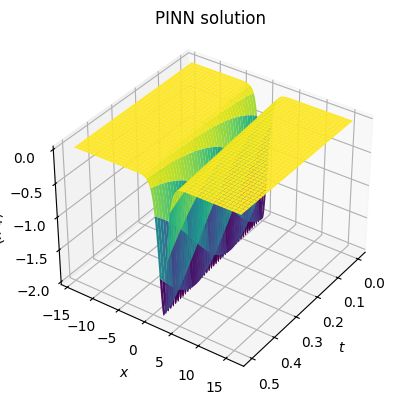

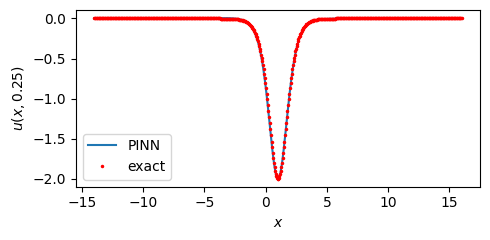

In [4]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)


C1 = tf.constant(3.02593, DTYPE)
C2 = tf.constant(1.01644, DTYPE)


a, b = -14., 16.
Tfinal = 0.5
lb = tf.constant([0., a], DTYPE)
ub = tf.constant([Tfinal, b], DTYPE)


def u_exact(t, x):
    arg = x - 4.0 * t
    sech2 = tf.math.cosh(arg) ** -2
    return -2.0 * sech2

def u_exact_t(t, x):
    with tf.GradientTape() as tape:
        tape.watch(t)
        val = u_exact(t, x)
    return tape.gradient(val, t)

def fun_u0(x):   # u(x,0)
    t0 = tf.zeros_like(x, DTYPE)
    return u_exact(t0, x)

def fun_u0_t(x): # u_t(x,0)
    t0 = tf.zeros_like(x, DTYPE)
    return u_exact_t(t0, x)


N0_val, N0_t, Nb_val, Nb_der, Nr = 400, 400, 400, 400, 4000
tf.random.set_seed(0)

t0      = tf.zeros((N0_val,1), DTYPE)
x0_samp = tf.random.uniform((N0_val,1), a, b, DTYPE)
X0_val, u0_val = tf.concat([t0, x0_samp], 1), fun_u0(x0_samp)

x0_t_samp = tf.random.uniform((N0_t,1), a, b, DTYPE)
X0_t, u0_t = tf.concat([t0, x0_t_samp], 1), fun_u0_t(x0_t_samp)

tb_val = tf.random.uniform((Nb_val,1), 0., Tfinal, DTYPE)
xa, xb = tf.ones_like(tb_val)*a, tf.ones_like(tb_val)*b
Xb_val = tf.concat([
    tf.concat([tb_val, xa], 1),
    tf.concat([tb_val, xb], 1)
], 0)

ub_val = tf.concat([
    u_exact(tb_val, xa),
    u_exact(tb_val, xb)
], 0)

tb_der = tf.random.uniform((Nb_der,1), 0., Tfinal, DTYPE)
Xb_der_all = tf.concat([
    tf.concat([tb_der, xa], 1),
    tf.concat([tb_der, xb], 1)
], 0)

tr = tf.random.uniform((Nr,1), 0., Tfinal, DTYPE)
xr = tf.random.uniform((Nr,1), a, b, DTYPE)
Xr = tf.concat([tr, xr], 1)


class PINN(tf.keras.Model):
    def __init__(self, layers, lb, ub):
        super().__init__()
        self.lb, self.ub = lb, ub
        self.hidden = [tf.keras.layers.Dense(w, activation='tanh')
                       for w in layers[:-1]]
        self.out = tf.keras.layers.Dense(layers[-1])

    def call(self, X):
        Z = 2.*(X - self.lb)/(self.ub - self.lb) - 1.
        for lyr in self.hidden:
            Z = lyr(Z)
        return self.out(Z)


def pde_residual(model, X):
    t, x = X[:, :1], X[:, 1:2]

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([t, x])
        u   = model(tf.concat([t, x], 1))
        u_t = tape.gradient(u, t)
        u_x = tape.gradient(u, x)
        u_xx = tape.gradient(u_x, x)
        u_xxx = tape.gradient(u_xx, x)
        u2_x = tape.gradient(u**2, x)

    del tape
    return u_t - C1 * u2_x + C2 * u_xxx

def ux_at(model, X):
    with tf.GradientTape() as tape:
        tape.watch(X)
        u = model(X)
    grads = tape.gradient(u, X)
    return grads[:, 1:2]

def loss_fn(model):
    r        = pde_residual(model, Xr)
    loss_res = tf.reduce_mean(tf.square(r))


    u0_pred = model(X0_val)
    with tf.GradientTape() as tape_t0:
        tape_t0.watch(X0_t)
        u_t0_pred = model(X0_t)
    ut0_pred = tape_t0.gradient(u_t0_pred, X0_t)[:, 0:1]

    loss_ic  = tf.reduce_mean(tf.square(u0_pred - u0_val)) + \
               tf.reduce_mean(tf.square(ut0_pred - u0_t))


    ub_pred = model(Xb_val)
    ux_pred = ux_at(model, Xb_der_all)
    loss_bc = tf.reduce_mean(tf.square(ub_pred - ub_val)) + \
              tf.reduce_mean(tf.square(ux_pred))

    return loss_res + loss_ic + loss_bc

@tf.function
def train_step(model, opt):
    with tf.GradientTape() as tape:
        loss = loss_fn(model)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss


layers = [2, 80, 80, 80, 80, 1]
model  = PINN(layers, lb, ub)

lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
              [3000, 7000], [1e-2, 1e-3, 1e-4])
opt = tf.keras.optimizers.Adam(lr_sched)

epochs = 2000
for ep in range(epochs+1):
    l = train_step(model, opt)
    if ep % 200 == 0:
        print(f"epoch {ep:5d}   loss = {l.numpy():.4e}")


N = 300
t_plot = np.linspace(0., Tfinal, N+1, DTYPE)
x_plot = np.linspace(a,   b,      N+1, DTYPE)
Tg, Xg = np.meshgrid(t_plot, x_plot)
Xgrid  = np.vstack([Tg.ravel(), Xg.ravel()]).T.astype(DTYPE)
Upred  = model(Xgrid).numpy().reshape(N+1, N+1)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Tg, Xg, Upred, cmap='viridis', linewidth=0)
ax.view_init(35, 35)
ax.set_xlabel(r'$t$'); ax.set_ylabel(r'$x$'); ax.set_zlabel(r'$u(t,x)$')
ax.set_title('PINN solution')
plt.tight_layout()


t_slice = 0.25
x_line  = np.linspace(a, b, 600, DTYPE)[:,None]
X_line  = tf.concat([t_slice*tf.ones_like(x_line), x_line], 1)
u_pred_slice  = model(X_line)
u_exact_slice = u_exact(t_slice, x_line)

plt.figure(figsize=(5,2.5))
plt.plot(x_line, u_pred_slice, label='PINN')
plt.plot(x_line, u_exact_slice, 'r.', ms=3, label='exact')
plt.xlabel(r'$x$'); plt.ylabel(fr'$u(x,{t_slice})$')
plt.legend(); plt.tight_layout(); plt.show()
